In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from indicators import get_sma, get_std
import numpy as np

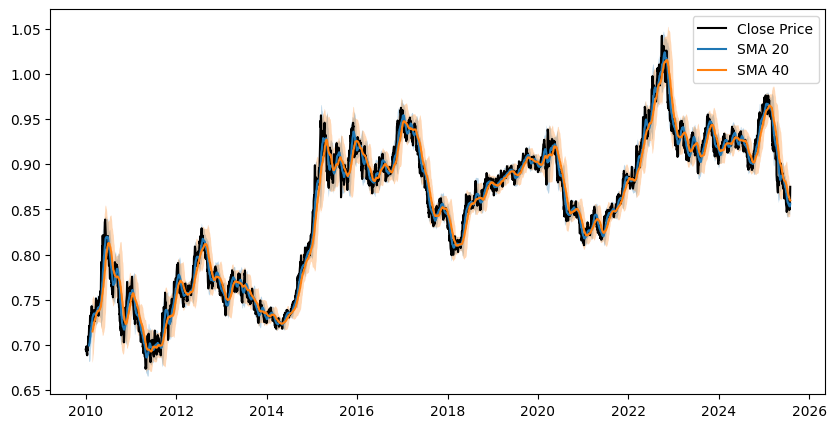

In [29]:
data = pd.read_csv("data/USDEUR=X_20100101_20250801.csv", index_col=0, parse_dates=True)
data.loc[:, 'log_close'] = np.log(data.Close)
indicators = pd.DataFrame(index=data.index)

windows = [20, 40]
for window in windows:
    indicators[f'sma_{window}'] = get_sma(data, window=window)
    indicators[f'std_{window}'] = get_std(data, window=window)
    indicators[f'2_std_{window}'] = 2*indicators[f'std_{window}']

# first_month = (data.index.year == 2020)
# data = data[first_month]
# indicators = indicators[first_month]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data.index, data['Close'], label='Close Price', color='black')
for window in windows:
    ax.plot(indicators.index, indicators[f'sma_{window}'], label=f'SMA {window}')
    ax.fill_between(indicators.index, indicators[f'sma_{window}'] - indicators[f'2_std_{window}'], indicators[f'sma_{window}'] + indicators[f'2_std_{window}'], alpha=0.3)
ax.legend()

In [49]:
import itertools

data = pd.read_csv("data/USDEUR=X_20100101_20250801.csv", index_col=0, parse_dates=True)
data.loc[:, 'log_close'] = np.log(data.Close)

# computing features for logistic regression
window_short = [20, 50]
window_long = [60, 100]
# cartesian produce of window short and long
window_combinations = list(itertools.product(window_short, window_long))
for short, long in window_combinations:
    # print(f"Short window: {short}, Long window: {long}")
    data[f'sma_diff_{short}_{long}'] = get_sma(data, window=short, col_name="log_close") - get_sma(data, window=long, col_name="log_close")

data['log_return'] = data['log_close'].diff()

data['price_movement'] = np.where(data['log_return'] > 0, 1, -1)
data.loc[:, 'target'] = data['price_movement'].shift(-1)
data = data.dropna()
# fig,ax = plt.subplots(figsize=(10,5))
# ax.hist(data['log_return'].dropna(), bins=50)
# plt.show()
data

,Close,High,Low,Open,Volume,log_close,sma_diff_20_60,sma_diff_20_100,sma_diff_50_60,sma_diff_50_100,log_return,price_movement,target
Date,,,,,,,,,,,,,
2010-05-20,0.80135,0.81307,0.79378,0.80710,0,-0.221457,0.036440,0.056888,0.004951,0.025399,-0.006877,-1,-1.0
2010-05-21,0.79573,0.80147,0.78914,0.80116,0,-0.228495,0.038234,0.058683,0.005424,0.025873,-0.007038,-1,1.0
2010-05-24,0.80972,0.81077,0.79713,0.79783,0,-0.211067,0.040759,0.061215,0.005906,0.026363,0.017429,1,1.0
2010-05-25,0.80998,0.82095,0.80736,0.80959,0,-0.210746,0.042354,0.062933,0.006450,0.027029,0.000321,1,1.0
2010-05-26,0.82149,0.82266,0.80919,0.80998,0,-0.196636,0.044481,0.065349,0.006898,0.027765,0.014110,1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-24,0.84931,0.85228,0.84835,0.84931,0,-0.163331,-0.019469,-0.036131,-0.004215,-0.020877,-0.002986,-1,1.0
2025-07-25,0.85062,0.85416,0.85029,0.85062,0,-0.161790,-0.019077,-0.035394,-0.004533,-0.020850,0.001541,1,-1.0
2025-07-28,0.85057,0.86133,0.84957,0.85057,0,-0.161849,-0.018576,-0.034666,-0.004899,-0.020989,-0.000059,-1,1.0


In [ ]:
from sklearn.linear_model import LogisticRegression

feat_cols = [col for col in data.columns if col.startswith('sma_diff')]

train_dates = ("2010-05-20", "2022-01-01")
test_dates = ("2022-02-01", "2023-12-31")
oos_dates = ("2024-02-01", "2025-12-31")

train_data = data[data.index.to_series().between(*train_dates)]
test_data = data[data.index.to_series().between(*test_dates)]
oos_data = data[data.index.to_series().between(*oos_dates)]

X_train = train_data[feat_cols]
y_train = train_data['target']

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [58]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")

X_test = test_data[feat_cols]
y_test = test_data['target']
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.5048
Test Accuracy: 0.4970
